Welcome to my exploration of red Portuguese vinho verde wines. Vinho verde is a common wine varietal in Portugal known for its light fruity flavor, slight effervescence, and overall drinkability on a warm summer day. While vinho verde is most commonly known for its white version, a red version also exists, and it is into these wines that we will delve. This data set comes from a 2009 publication by Cortez et al titled "Modeling wine preferences by data mining from physicochemical properties." The dataset is widely available on the internet, for example at https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009. To help holistically understand the data better, I rely on Wine Folly (https://winefolly.com/) and some other sources for information about wines.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


sns.set_palette("bright")

# Import the wine data set
data = pd.read_csv('wineQualityReds.csv', usecols=(np.arange(12)+1))

# Fix outliers in chlorides and residual sugar for better visualization
data["chlorides"] = pd.Series([min(x, 0.14) for x in data["chlorides"]])
data["residual.sugar"] = pd.Series([min(x, 5) for x in data["residual.sugar"]])

# Add units to the column names
col_names = data.columns
ind_gpdm3 = [0, 1, 2, 3, 4, 7, 9]
col_gpdm3 = [col_names[i] for i in ind_gpdm3]
col_names_units = [name+" (g/dm3)" for name in col_gpdm3]
mgpdm3 = [name+" (mg/dm3)" for name in col_names[5:7]]
col_names_units.insert(5, mgpdm3[0])
col_names_units.insert(6, mgpdm3[1])
col_names_units.insert(7, col_names[7]+" (g/cm3)")
col_names_units.insert(8, col_names[8])
col_names_units.insert(10, col_names[10]+" (%)")
add_units = {col_names[i]: col_names_units[i] for i in range(11)}
data.rename(columns=add_units, inplace=True)

To start, let's look at the columns in the dataset.

In [116]:
print(data.columns)

Index(['fixed.acidity (g/dm3)', 'volatile.acidity (g/dm3)',
       'citric.acid (g/dm3)', 'residual.sugar (g/dm3)', 'chlorides (g/dm3)',
       'free.sulfur.dioxide (mg/dm3)', 'total.sulfur.dioxide (mg/dm3)',
       'density (g/cm3)', 'pH', 'density (g/dm3)', 'alcohol (%)', 'quality'],
      dtype='object')


The list above shows the column names in the data set. The last column, quality, gives the quality score for each wine, as given by a panel of experts who tasted the wine. This is the column that will guide our quest to understand what creates good wine. The first three columns pertain to acid in various ways. The next two columns give us sugar and salt (sodium chloride) values. These are common culinary properties with which most people are familiar. The remaining columns are more wine specific. Sulfur dioxide is common in wines becuase is stabilizes the compounds leading to a more predictable wine; however, sulfur dioxide is also the smell of volcano gas, so care must be taken not to overuse it. pH is another way of measuring the influence of acids on the wine, and density is the mass per volume of the wine, which generally is very close to 1 g/cm3, that of water.

Since the first 5 columns lend themselves best to intuition based on common culinary experiences, everything from drinking lemonande to cooking steak, let's start our analysis there! To get a sense of the typical values and and their relationship to quality, I made histograms of the individual column values, and the qaulity of wines with those values is shown by colors. I have also slightly modified the sugar and salt columns for outliers, which you can see more about in my fitting notebook.

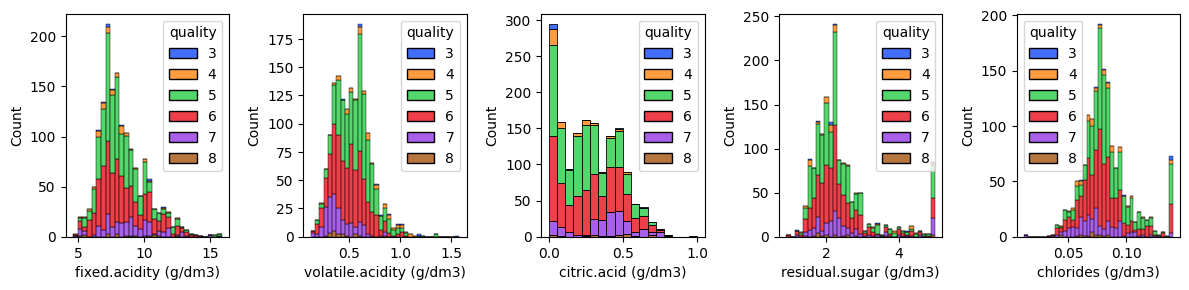

In [117]:
col_names = data.columns
fig, axs = plt.subplots(1,5, figsize=(12,3))
for i in range(5):
    sns.histplot(data=data, x=col_names[i], hue="quality", multiple='stack', palette='bright', ax=axs[i%5])
fig.tight_layout()

Acids can be very culinarily polarizating. Think about the difference between sucking on a lemon, versus putting a splash of lemon juice in your glass of water, versus drinking a Coke. You wouldn't want to suck on the lemon, but you probably would enjoy the Coke. Why? Because the lemon tastes way too sour and acidic! But, by some measures, the Coke actually has more acid. How then is Coke palatable enough to spur the creation of an almost-300B$ company while nobody consumes lemon juice without majorly diluting it first? The answer, conveniently, lies in the use of sugar and salt. But, then if lemon juice is so unpalatable, why does Coca-Cola own Minute Maid, a lemonade that touts itself as "made with real lemons?" This also has to do with copious amounts of sugar, but also the wonderful taste associated with citric acid. Yes, the same citric acid present in our vinho verde wines! And, lest you think that adding sugar and salt to any acid will create a delishious beverage, consider the last time you vinegar-ade. Probably never. And for good reason. Vinegar, or acetic acid, is volatile, and that quantity is respresented by the volatile acidity. Finally, fixed acid, in this case tartaric acid, both stabilizes the wine and provides flavor. Tartaric acid is most prevalent in grapes, but also occurs naturally in avocado apricot, and tamarind. When determining wine quality, we can cearly see from the plots above that fixed and volatile acidity correlate with wine quality. 

<AxesSubplot:xlabel='quality', ylabel='volatile.acidity (g/dm3)'>

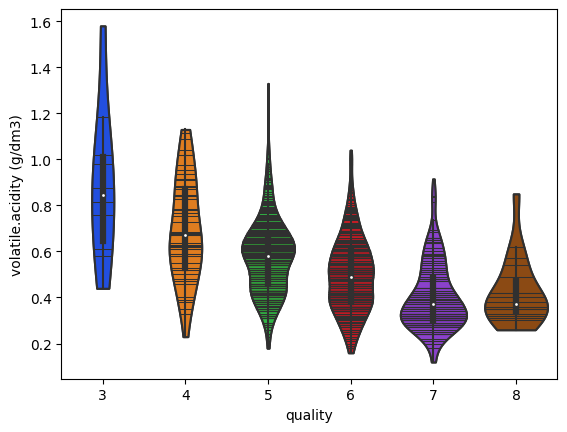

In [118]:
sns.violinplot(data=data, x="quality", y="volatile.acidity (g/dm3)", cut=0)
sns.violinplot(data=data, x="quality", y="volatile.acidity (g/dm3)", cut=0, inner="stick")

<AxesSubplot:xlabel='quality', ylabel='citric.acid (g/dm3)'>

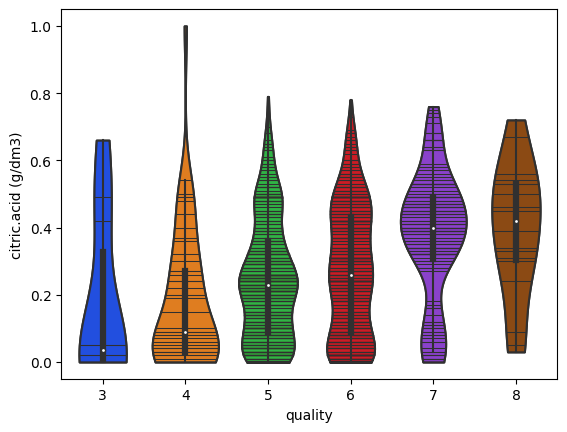

In [119]:
sns.violinplot(data=data, x="quality", y="citric.acid (g/dm3)", cut=0, scale="area", inner="box")
sns.violinplot(data=data, x="quality", y="citric.acid (g/dm3)", cut=0, scale="area", inner="stick")

The two violin plots of the volatile acidity, vinegar; and citric acid, fruitiness, present in the wine show the trends we would anticipate just by the descriptions of each type of acid. The width of the violin plot at a given acid level shows smoothed proportion of wines of the given quality that have that acid level. As a reminder of the individual data points, horizontal lines inside each violin represent an individual datum. The white dots in the center of each violin show the median value.

In [181]:
sns.color_palette("bright")[4]
my_pal = [sns.color_palette("PiYG")[0], sns.color_palette("PiYG")[1], sns.color_palette("PiYG")[4], sns.color_palette("PiYG")[5]] 

In [222]:
std_scaler = StandardScaler()
X_cols = data.columns
X = std_scaler.fit_transform(data)
X = pd.DataFrame(X, columns=X_cols)

kmeans3 = KMeans(n_clusters=3)
kmeans4 = KMeans(n_clusters=4)
kmeans5 = KMeans(n_clusters=4)
data["clusteracid"] = kmeans3.fit_predict(X[["volatile.acidity (g/dm3)", "fixed.acidity (g/dm3)", "citric.acid (g/dm3)"]])
data["clusterss"] = kmeans4.fit_predict(X[["residual.sugar (g/dm3)", "chlorides (g/dm3)"]])
data["clusterssacid"] = kmeans5.fit_predict(X[["fixed.acidity (g/dm3)",
                                               "citric.acid (g/dm3)","residual.sugar (g/dm3)", "chlorides (g/dm3)"]])

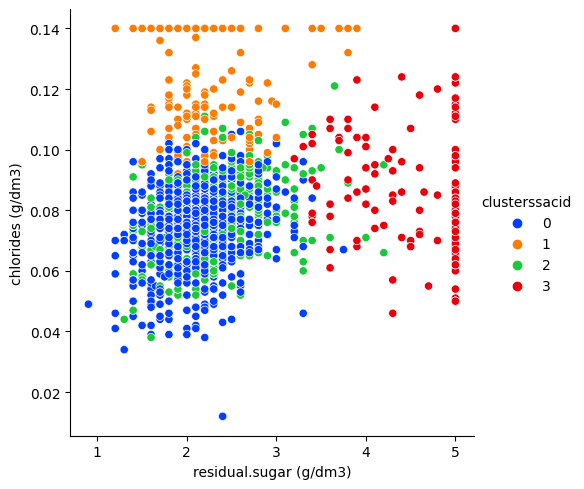

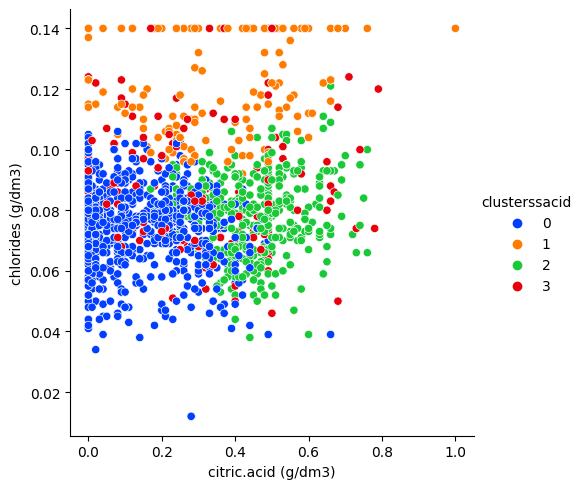

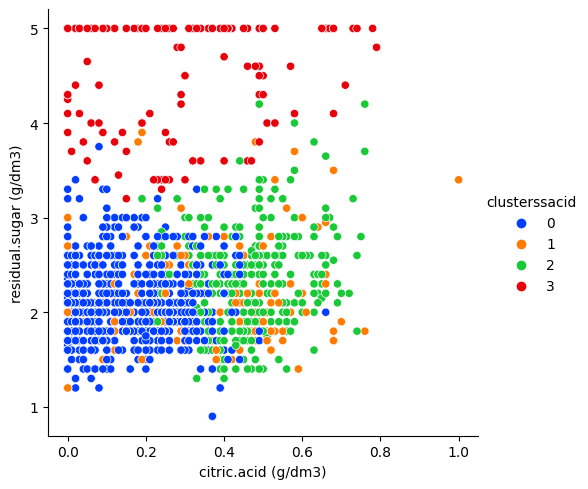

In [225]:
#sns.relplot(x="volatile.acidity (g/dm3)", y="citric.acid (g/dm3)", hue="clusteracid", palette='PuRd', data=data)
#sns.relplot(x="fixed.acidity (g/dm3)", y="citric.acid (g/dm3)", hue="clusteracid", palette='PuRd', data=data)
#sns.relplot(x="volatile.acidity (g/dm3)", y="fixed.acidity (g/dm3)", hue="clusteracid", palette='PuRd', data=data)
sns.relplot(x="residual.sugar (g/dm3)", y="chlorides (g/dm3)", hue="clusterssacid", palette="bright", data=data)
sns.relplot(x="citric.acid (g/dm3)", y="chlorides (g/dm3)", hue="clusterssacid", palette="bright", data=data)
sns.relplot(x="citric.acid (g/dm3)", y="residual.sugar (g/dm3)", hue="clusterssacid", palette="bright", data=data)

<AxesSubplot:xlabel='clusterssacid', ylabel='quality'>

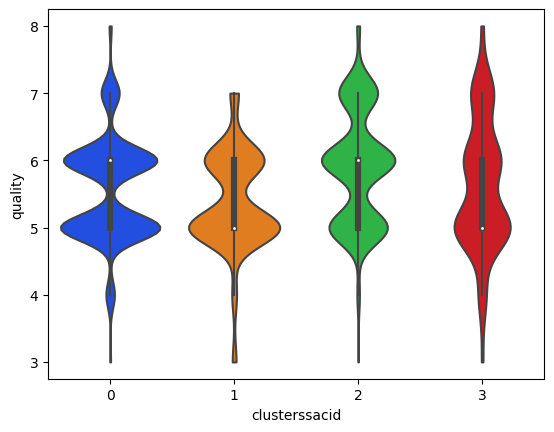

In [223]:
sns.violinplot(data=data, x="clusterssacid", y="quality", cut=0, scale="area", inner="box")
#sns.violinplot(data=data, x="clusterssacid", y="quality", cut=0, scale="area", inner="stick")

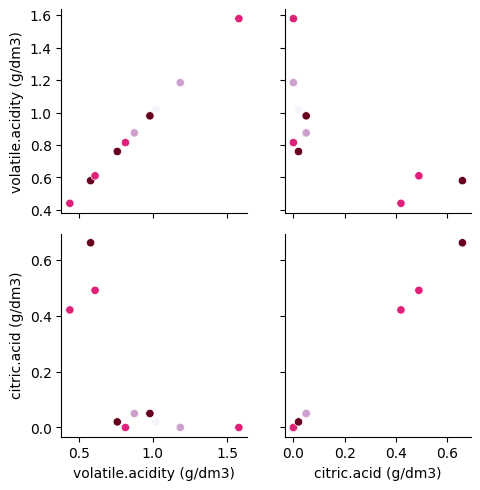

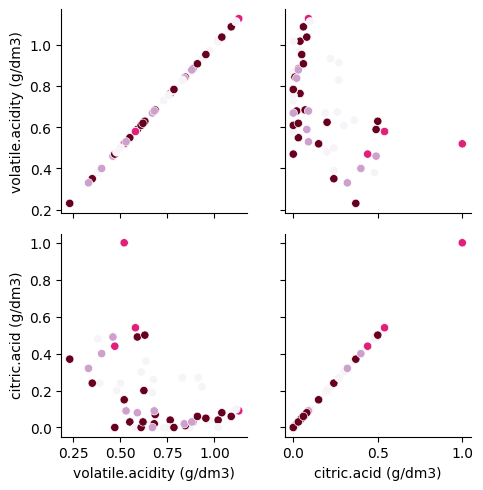

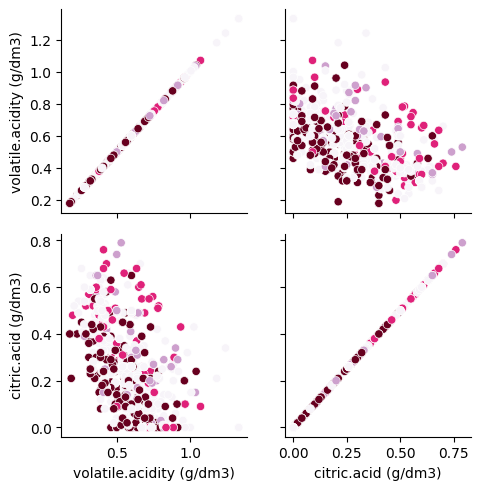

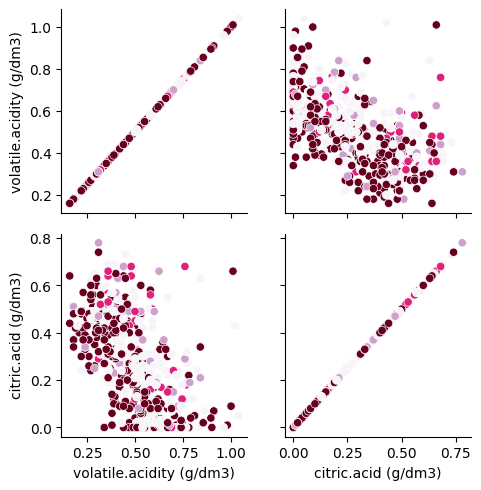

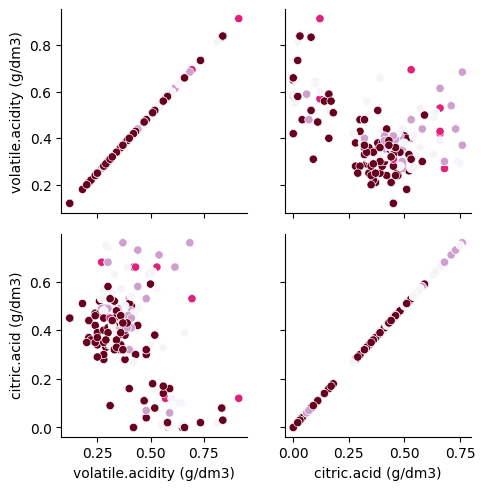

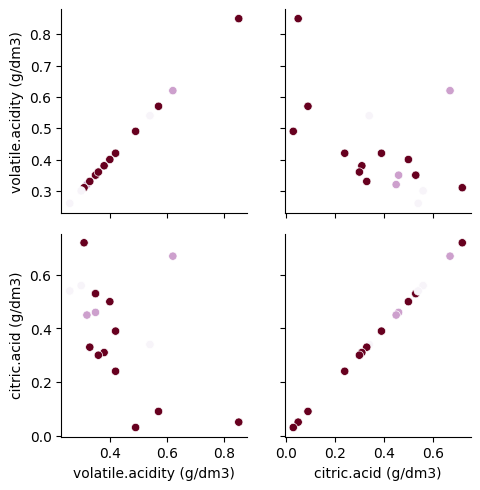

In [107]:
size = 4
#sns.jointplot(x=data["fixed.acidity"], y=data["volatile.acidity"], kind='scatter', hue=np.sign(data["quality"]-6.5), palette="bright", height=size)
for i in range(3,9):
    g=sns.PairGrid(data.loc[data["quality"]==i], vars=["volatile.acidity (g/dm3)", "citric.acid (g/dm3)"],
                   #hue="clusteracid", palette=[sns.color_palette("bright")[i-3]])
                   hue="clusterss", palette="PuRd")
    g.map(sns.scatterplot)
#g=sns.PairGrid(data.loc[data["quality"]==], vars=["volatile.acidity (g/dm3)", "citric.acid (g/dm3)"],
#               hue="quality", palette=[sns.color_palette("bright")[2]])
#g.map(sns.scatterplot)
#sns.jointplot(x=data.loc[data["volatile.acidity (g/dm3)"]<0.4, "volatile.acidity (g/dm3)"],
#              y=data.loc[data["volatile.acidity (g/dm3)"]<0.4, "citric.acid (g/dm3)"],
#              hue=data["quality"], palette="bright", kind='kde')

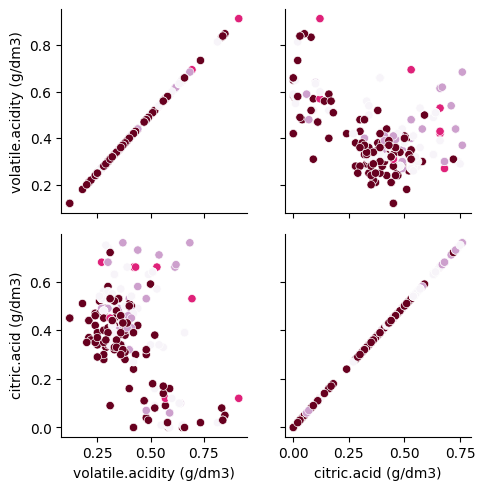

In [109]:
g=sns.PairGrid(data.loc[data["quality"]>6.5], vars=["volatile.acidity (g/dm3)", "citric.acid (g/dm3)"],
               #hue="clusteracid", palette=[sns.color_palette("bright")[i-3]])
               hue="clusterss", palette="PuRd")
g.map(sns.scatterplot)

In [177]:
my_pal = [sns.color_palette("PiYG")[0], sns.color_palette("PiYG")[1], sns.color_palette("PiYG")[4], sns.color_palette("PiYG")[5]] 

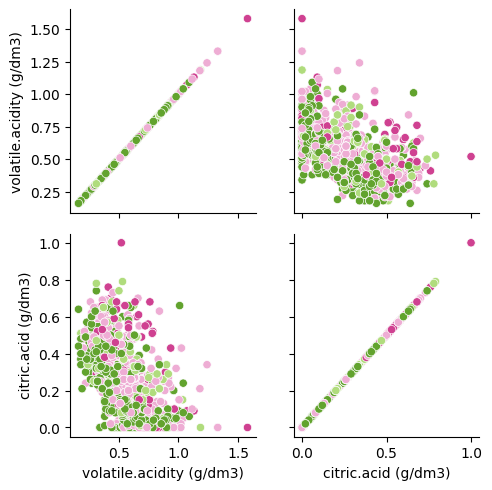

In [178]:
g=sns.PairGrid(data.loc[data["quality"]<6.5], vars=["volatile.acidity (g/dm3)", "citric.acid (g/dm3)"],
               #hue="clusteracid", palette=[sns.color_palette("bright")[i-3]])
               hue="clusterss", palette=my_pal)
g.map(sns.scatterplot)

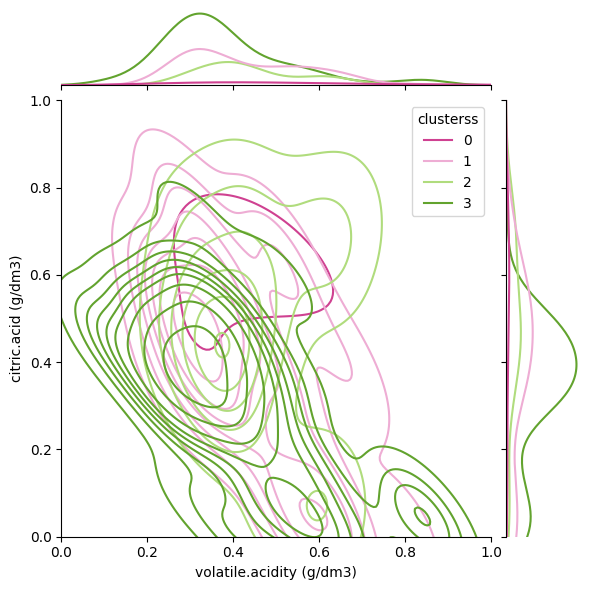

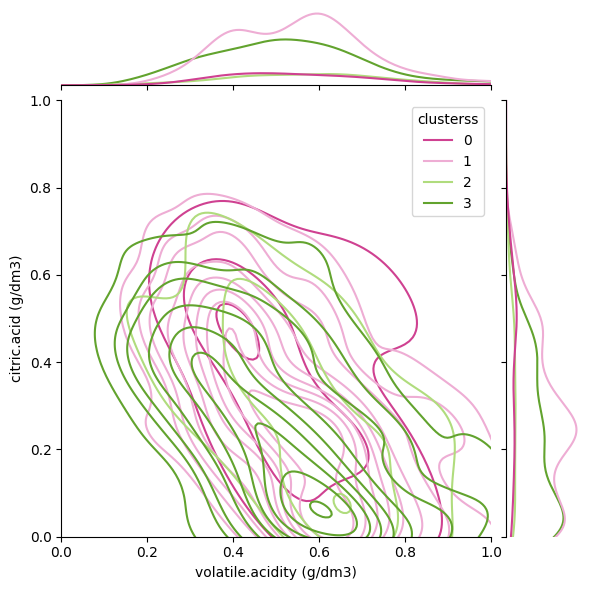

In [179]:
goodinds = data[data["quality"] > 6.5].index
sns.jointplot(x=data.loc[goodinds,"volatile.acidity (g/dm3)"],
              y=data.loc[goodinds,"citric.acid (g/dm3)"],
              palette=my_pal, hue=data.loc[goodinds, "clusterss"], xlim=[0, 1], ylim=[0, 1], kind='kde')

badinds = data[data["quality"] < 6.5].index
sns.jointplot(x=data.loc[badinds,"volatile.acidity (g/dm3)"],
              y=data.loc[badinds,"citric.acid (g/dm3)"],
              palette=my_pal, hue=data.loc[badinds, "clusterss"], xlim=[0, 1], ylim=[0, 1], kind='kde')

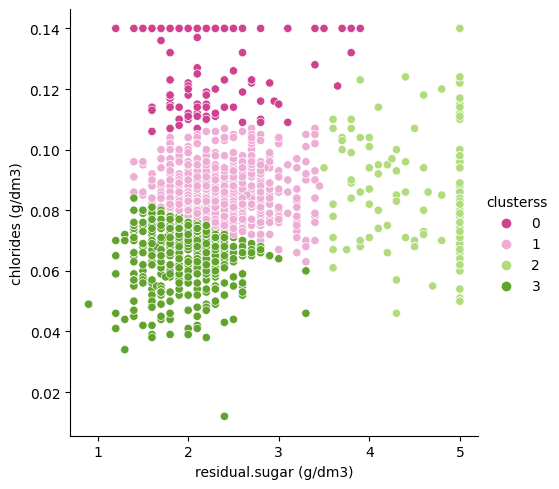

In [182]:
sns.relplot(x="residual.sugar (g/dm3)", y="chlorides (g/dm3)", hue="clusterss", palette=my_pal, data=data)

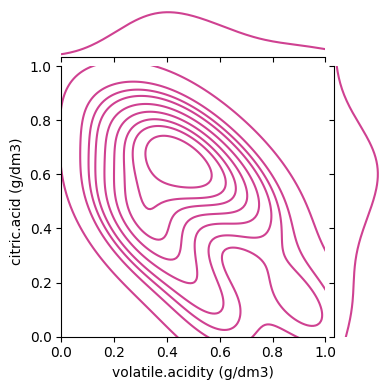

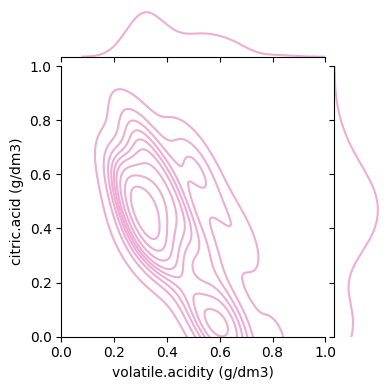

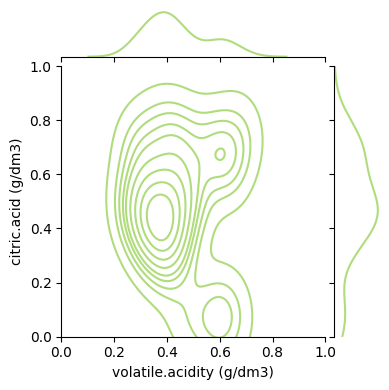

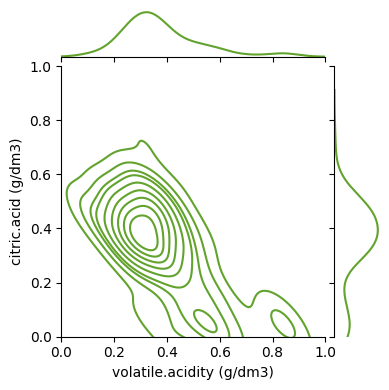

In [176]:
goodinds = [data[(data["quality"] > 6.5) & (data["clusterss"] ==i)].index for i in range(4)]
my_pal = [sns.color_palette("PiYG")[0], sns.color_palette("PiYG")[1], sns.color_palette("PiYG")[4], sns.color_palette("PiYG")[5]] 
for i in range(4):
    sns.jointplot(x=data.loc[goodinds[i],"volatile.acidity (g/dm3)"],
                  y=data.loc[goodinds[i],"citric.acid (g/dm3)"],
                  color=my_pal[i], xlim=[0, 1], ylim=[0, 1], kind='kde', height=4)

More sources:
    https://www.compoundchem.com/2016/02/25/a-guide-to-common-fruit-acids/
    https://www.guildsomm.com/public_content/features/articles/b/jamie_goode/posts/the-taste-of-wine-acid-sweetness-and-tannin
        